<a href="https://colab.research.google.com/github/daveking63/Bollywood/blob/master/Milestone_1_v4_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
data_to_load = files.upload()

Saving india_cpi_2020.txt to india_cpi_2020 (2).txt
Saving verdict_ranks.txt to verdict_ranks (2).txt
Saving bw_success_measures.txt to bw_success_measures (2).txt


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# load data tab separated text file, converting to pandas DataFrame
import io
df_sm = pd.read_csv(io.BytesIO(data_to_load['bw_success_measures.txt']),sep='\t')

In [5]:
# Total sample size, variables, missing values, data types for download file
df_sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2963 entries, 0 to 2962
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   film           2963 non-null   object 
 1   id             2963 non-null   int64  
 2   rank           2963 non-null   int64  
 3   release_date   2963 non-null   object 
 4   verdict        2963 non-null   object 
 5   budget         2797 non-null   float64
 6   first_week     2466 non-null   float64
 7   tot_net_gross  2963 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 185.3+ KB


In [6]:
# Summary of aggregate measures for key financial variables
# mean, std, min ... all in Indian Crores (10M rupees)

df_sm[['budget','first_week','tot_net_gross']].describe()

,budget,first_week,tot_net_gross
count,2797.000000,2466.000000,2963.00000
mean,13.391911,9.523644,12.64578
std,27.234132,22.247333,32.94777
min,0.080000,0.003000,0.00500
25%,1.250000,0.435000,0.23350
50%,4.500000,1.871500,1.67500
75%,14.000000,6.737500,8.96750
max,575.000000,246.470000,510.36000


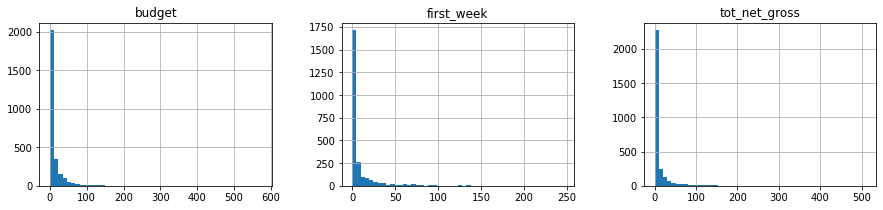

In [7]:
df_sm.loc[0:,['budget','first_week','tot_net_gross']].hist(bins=50,figsize=(15,3), layout=(1,3));

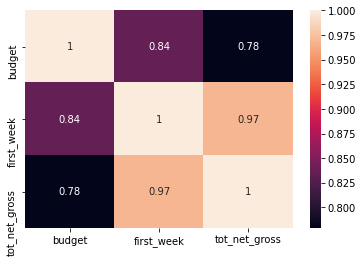

In [8]:
# These are highly skewed to the left and as a consequence the variables
# highly intercorrelated because of the overwhelming majority of low values
# (although technically shouldn't report this because of skew)

corr_list = ['budget','first_week','tot_net_gross']
corr = pd.DataFrame()
for var1 in corr_list:
    for var2 in corr_list:
        corr.loc[var1, var2] = df_sm.corr().loc[var1, var2]
sns.heatmap(corr, annot=True);

In [9]:
# As a precursor to handling missing data, create and
# insert the year the film was made

# The requires converting the type of the release_date 
# from a (string) object to a 'datetime'. After the conversion,
# insert a new column release_year (int) just after the release_date column

import datetime
release_year = pd.Series([])
df_sm['release_date'] = pd.to_datetime(df_sm['release_date'])
release_year = df_sm['release_date'].map(lambda x: int(x.strftime('%Y')))
df_sm.insert(4, "release_year", release_year)
df_sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2963 entries, 0 to 2962
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   film           2963 non-null   object        
 1   id             2963 non-null   int64         
 2   rank           2963 non-null   int64         
 3   release_date   2963 non-null   datetime64[ns]
 4   release_year   2963 non-null   int64         
 5   verdict        2963 non-null   object        
 6   budget         2797 non-null   float64       
 7   first_week     2466 non-null   float64       
 8   tot_net_gross  2963 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 208.5+ KB


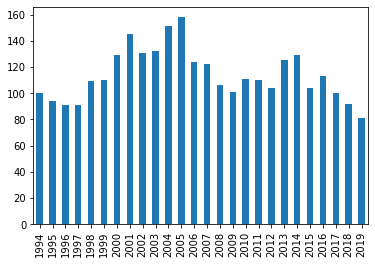

In [10]:
# distribution of number of movies by year (1994-2019)
df_sm['release_year'].value_counts().sort_index().plot(kind='bar');

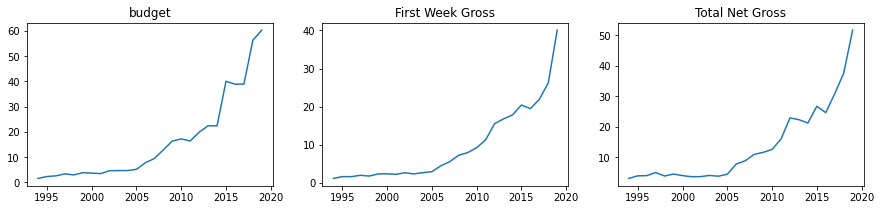

In [11]:
# Question: do financial variables vary by release_year

df_years_groups = df_sm.groupby(['release_year'])[['budget','first_week','tot_net_gross']].mean()
#print(df_years_groups)

fig, axs = plt.subplots(1, 3, figsize=(15,3))
(ax1, ax2, ax3) = axs
ax1.plot(df_years_groups.index, df_years_groups['budget'])
ax1.set_title('budget')
ax2.plot(df_years_groups.index, df_years_groups['first_week'])
ax2.set_title('First Week Gross')
ax3.plot(df_years_groups.index, df_years_groups['tot_net_gross'])
ax3.set_title('Total Net Gross');

In [12]:
# Handling Missing Data

# In this dataset there are only two variables with missing values -
# budget and first_week revenues. There are variety of ways to
# handle missing values:
# 1. drop columns with missing values - not an option since both
# columns are critical
# 2. drop rows with missing values - there are 166 rows with missing
# budgets and 497 with missing first_week revenues. This would eliminate
# at least 500 rows (about 17%). Since financial data is skewed to the left
# this would raise the budget and first_week figures
# 3. impute a value for the missing values (e.g. use the overall mean or median
# each variable). This would probably lower the figures.

# Here, we've decided on a combination - eliminate the rows with missing first_week
# revenues and impute values for the missing budgets using median values by year.

# In both cases we've also decided to copy the original dataset and work with a
# new version.  This way if we decide latter to alter the plan we don't have to 
# go back to square 1.

In [13]:
# Step 1: Eliminate rows with missing first_week revenues
# new dataframe is called df_sm_miss

df_sm_miss = df_sm.copy(deep=True)
df_sm_miss = df_sm_miss.dropna(subset=['first_week'])
df_sm_miss.index = range(len(df_sm_miss.index))
print(df_sm_miss.info())

df_sm_miss_agg = df_sm_miss[['budget','first_week','tot_net_gross']].describe()
df_sm_miss_agg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   film           2466 non-null   object        
 1   id             2466 non-null   int64         
 2   rank           2466 non-null   int64         
 3   release_date   2466 non-null   datetime64[ns]
 4   release_year   2466 non-null   int64         
 5   verdict        2466 non-null   object        
 6   budget         2354 non-null   float64       
 7   first_week     2466 non-null   float64       
 8   tot_net_gross  2466 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 173.5+ KB
None


,budget,first_week,tot_net_gross
count,2354.000000,2466.000000,2466.000000
mean,15.857508,9.523644,15.169829
std,29.033149,22.247333,35.586895
min,0.100000,0.003000,0.023000
25%,2.500000,0.435000,0.635750
50%,6.000000,1.871500,3.029000
75%,18.000000,6.737500,12.328750
max,575.000000,246.470000,510.360000


In [14]:
# number of budget values currently missing
df_sm_miss['budget'].isna().sum()


112

In [15]:
# Step 2 - imputing values for missing budget values
# The imputed values are based on the median budget values
# for the year the film has released

# the current sample size is now 2466 vs. the original 2963
# still substantially larger than the other studies

df_sm_miss['budget'] = df_sm_miss['budget'].fillna(df_sm_miss.groupby('release_year')['budget'].transform('median'))

df_sm_miss_agg = df_sm_miss[['budget','first_week','tot_net_gross']].describe()
df_sm_miss_agg

,budget,first_week,tot_net_gross
count,2466.000000,2466.000000,2466.000000
mean,16.373915,9.523644,15.169829
std,28.488105,22.247333,35.586895
min,0.100000,0.003000,0.023000
25%,2.500000,0.435000,0.635750
50%,6.750000,1.871500,3.029000
75%,20.000000,6.737500,12.328750
max,575.000000,246.470000,510.360000


In [16]:
#df_sm_miss.loc[0:,['budget','first_week','tot_net_gross']].hist(bins=50,figsize=(12,3), layout=(1,3));

In [17]:
#df_sm_agg = df_sm[['budget','first_week', 'tot_net_gross']].describe()
#df_agg = pd.concat([df_sm_miss_agg, df_sm_agg], axis=1, keys=('Missing','Original'))
#df_agg

In [18]:
# Adjusting for Currency Inflation

In [19]:
# read consumer price index ratio for years between 1994 & 2019 with base year of 2020
df_cpi = pd.read_csv(io.BytesIO(data_to_load['india_cpi_2020.txt']),sep='\t')
df_cpi.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       27 non-null     int64  
 1   CPI        27 non-null     float64
 2   CPI_Ratio  27 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 776.0 bytes


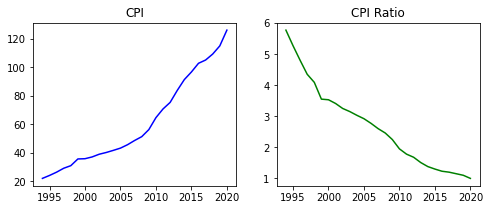

In [20]:
df_cpi.iloc[0:,0].head()

fig, axs = plt.subplots(1, 2, figsize=(8,3))
(ax1, ax2) = axs
ax1.plot(df_cpi.iloc[0:,0], df_cpi.iloc[0:,1], color='blue')
ax1.set_title('CPI')
ax2.plot(df_cpi.iloc[0:,0], df_cpi.iloc[0:,2], color='green')
ax2.set_title('CPI Ratio');

In [21]:
# create a dictionary of CPI ratios with year as key
dict_cpi = dict(zip(df_cpi.iloc[0:,0], df_cpi.iloc[0:,2]))
print(dict_cpi)

{1994: 5.77, 1995: 5.27, 1996: 4.8, 1997: 4.35, 1998: 4.09, 1999: 3.55, 2000: 3.53, 2001: 3.41, 2002: 3.25, 2003: 3.15, 2004: 3.03, 2005: 2.92, 2006: 2.77, 2007: 2.6, 2008: 2.46, 2009: 2.25, 2010: 1.95, 2011: 1.78, 2012: 1.68, 2013: 1.51, 2014: 1.38, 2015: 1.3, 2016: 1.23, 2017: 1.2, 2018: 1.15, 2019: 1.1, 2020: 1.0}


In [22]:
# adjust budget, first_week, tot_net_gross for inflation
for i in range(df_sm_miss.shape[0]):
  yr = df_sm_miss.loc[i,'release_year']
  cpi_ratio = dict_cpi[yr]
  df_sm_miss.loc[i,'budget_adjust'] = round(df_sm_miss.loc[i,'budget']*cpi_ratio,3)
  df_sm_miss.loc[i,'first_week_adjust'] = round(df_sm_miss.loc[i,'first_week']*cpi_ratio,3)
  df_sm_miss.loc[i,'tot_net_gross_adjust'] = round(df_sm_miss.loc[i,'tot_net_gross']*cpi_ratio,3)

In [23]:
 print(df_sm_miss.info())
 print(df_sm_miss.loc[0:,'budget_adjust':].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   film                  2466 non-null   object        
 1   id                    2466 non-null   int64         
 2   rank                  2466 non-null   int64         
 3   release_date          2466 non-null   datetime64[ns]
 4   release_year          2466 non-null   int64         
 5   verdict               2466 non-null   object        
 6   budget                2466 non-null   float64       
 7   first_week            2466 non-null   float64       
 8   tot_net_gross         2466 non-null   float64       
 9   budget_adjust         2466 non-null   float64       
 10  first_week_adjust     2466 non-null   float64       
 11  tot_net_gross_adjust  2466 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 231.3+ K

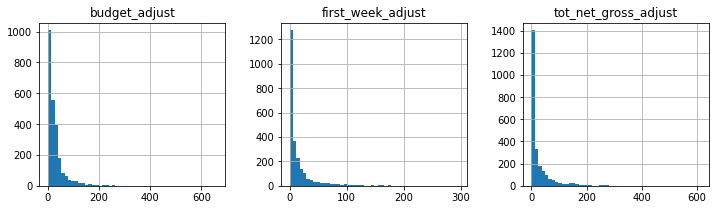

In [24]:
df_sm_miss.loc[0:,['budget_adjust','first_week_adjust','tot_net_gross_adjust']].hist(bins=50,figsize=(12,3), layout=(1,3));

In [25]:
#df_sm_miss.loc[0:,'budget':].describe()
#df_sm_miss[['budget','budget_adjust','first_week','first_week_adjust','tot_net_gross','tot_net_gross_adjust']].describe()

In [26]:
from scipy.stats import kurtosis
from scipy.stats import skew

col_sel = ['budget_adjust','first_week_adjust','tot_net_gross_adjust',]
for var in col_sel:
  data = df_sm_miss[var]
  print(var, round(skew(data),3), round(kurtosis(data),3))


budget_adjust 4.62 44.322
first_week_adjust 3.999 21.114
tot_net_gross_adjust 4.034 23.475


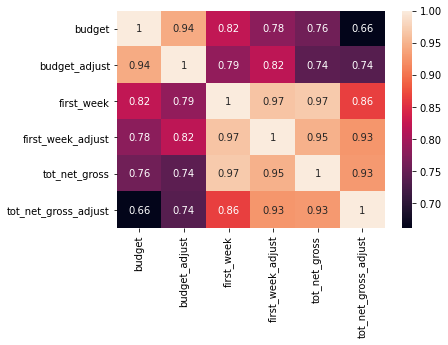

In [27]:
corr_list = ['budget','budget_adjust','first_week','first_week_adjust','tot_net_gross','tot_net_gross_adjust']
corr = pd.DataFrame()
for var1 in corr_list:
    for var2 in corr_list:
        corr.loc[var1, var2] = df_sm_miss.corr().loc[var1, var2]
sns.heatmap(corr, annot=True);

In [28]:
# Use a subset of films to demonstrate the change with adjustments to inflation
# All Time Blockbusters

df_sm_miss[df_sm_miss.verdict == 'All Time Blockbuster'][['film','rank','release_year','budget','budget_adjust','first_week','first_week_adjust','tot_net_gross','tot_net_gross_adjust']]

,film,rank,release_year,budget,budget_adjust,first_week,first_week_adjust,tot_net_gross,tot_net_gross_adjust
0,Hum Aapke Hain Koun..!,1,1994,6.25,36.062,0.680,3.924,72.465,418.123
1,Bahubali 2 - The Conclusion,2,2017,195.00,234.000,246.470,295.764,510.360,612.432
2,Gadar - Ek Prem Katha,3,2001,19.00,64.790,9.280,31.645,76.880,262.161
3,Dilwale Dulhania Le Jayenge,4,1995,4.00,21.080,3.373,17.776,53.313,280.960
4,Raja Hindustani,5,1996,5.75,27.600,3.650,17.520,43.145,207.096
5,Dangal,6,2016,132.00,162.360,192.380,236.627,374.530,460.672
6,Border,7,1997,10.00,43.500,6.190,26.926,39.455,171.629
7,Kuch Kuch Hota Hai,8,1998,10.00,40.900,5.640,23.068,46.865,191.678
8,Bajrangi Bhaijaan,9,2015,125.00,162.500,183.520,238.576,315.490,410.137
9,PK,10,2014,122.00,168.360,181.260,250.139,337.725,466.060


In [29]:
# Calculate Other Measures of Success

# In addition to the base and adjusted versions of gross revenue (first week, total net, etc.),
# a variety of other measures have also been used (in previous studies).  As noted, some of these 
# involve  simple differences and ratios of gross revenues to budget. Two examples are:

#   1.  If (P * total gross revenue - budget) > 0, then 'success'(1) else 'flop'(0) 
#       where 'P' represents the proportion of gross that remains after future costs
#       (e.g. % of revenues payable to stars at a future date). They used .5 but should be
#       higher since this is net gross revenue.
#        
#   2.  Let (gross_cost_ratio = total gross revenue)/budget.
#       If x < c1 then 'low grossing'(1), elif x >= c2 then 'high grossing'(3), else 'moderate grossing'(2).
#       Again, originally c1 = 1.5 and c2 = 2.5 but I would modify to something like 1.0 and 2.0.
#
#  Other studies focus on external critical evaluations of success. A case in point is the BOI 'verdict' variable
#  in the current dataframe.  This is an ordinal variable whose (string) values are:
#  'Disaster', 'Flop', 'Below Average', 'Average', 'Semi Hit', 'Hit', 'Super Hit', 'Blockbuster', 'All Time Blockbuster'
#  These can be easily converted to numerical values (1-9) for use in ML modeling.
#
#  The task at hand is to create (numerical) measures for these three examples and add them as columns to the existing
#  dataframe. Again, using standard pandas methods, briefly describe their distributions. Finally, using appropriate
#  'association' measures for ordinal variables (e.g. Spearman's Rho), determine which, if any, is better as a measure
#  of success. 

0.0    1972
1.0     494
Name: success_flop, dtype: int64 



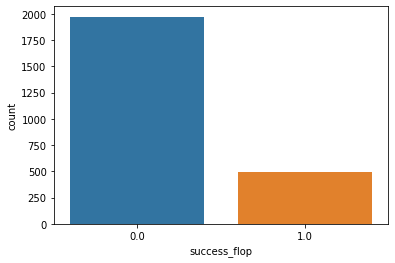

In [30]:
# Success based on profit = 
for i in range(0,df_sm_miss.shape[0]):
  revenue = df_sm_miss.loc[i,'tot_net_gross_adjust']
  budget = df_sm_miss.loc[i,'budget_adjust']
  profit = (.8 * revenue) - budget
  if profit > 0:
    df_sm_miss.loc[i,'success_flop'] = 1 # success
  else:
    df_sm_miss.loc[i,'success_flop'] = 0 # flop

print(df_sm_miss.success_flop.value_counts(),'\n')
ax = sns.countplot(x="success_flop",data=df_sm_miss);

1.0    1766
2.0     523
3.0     177
Name: profit_ratio, dtype: int64


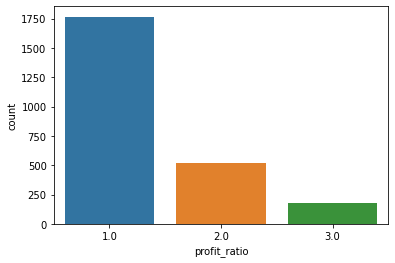

In [31]:
# Success measured by profit ratio = gross_rev/budget
# 3 ordinal values: low = profit ratio - < 1.0; moderate - profit ratio >= 1.0 and < 2.0; high - >= 2.0

for i in range(0,df_sm_miss.shape[0]):
  revenue = df_sm_miss.loc[i,'tot_net_gross_adjust']
  budget = df_sm_miss.loc[i,'budget_adjust']
  profit_ratio = revenue/budget
  if profit_ratio < 1.0:
    df_sm_miss.loc[i,'profit_ratio'] = 1 # low grossing
  elif profit_ratio >= 2.0:
    df_sm_miss.loc[i,'profit_ratio'] = 3 # high grossing
  else:
    df_sm_miss.loc[i,'profit_ratio'] = 2 # moderate grossing

print(df_sm_miss.profit_ratio.value_counts())
ax = sns.countplot(x="profit_ratio",data=df_sm_miss);

1    1247
2     633
6     132
4     129
5     102
3      97
7      72
8      42
9      12
Name: verdict_rank, dtype: int64


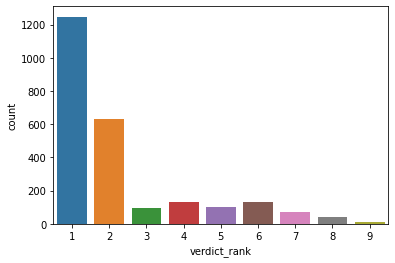

In [32]:
# Insert a new variable 'verdict_ranking' that assigns a numerical value 1-9
# to the ordinal variable 'verdict' whose string values are:
# 'Disaster', 'Flop', 'Below Average', 'Average', 'Semi Hit', 'Hit', 'Super Hit', 'Blockbuster', 'All Time Blockbuster'

# read file containing verdicts and associated verdict ranks
df_verdicts = pd.read_csv(io.BytesIO(data_to_load['verdict_ranks.txt']),sep='\t')

# create a dictionary associating verdicts with verdict ranks
verdict_dict = dict(zip(df_verdicts.verdict, df_verdicts.verdict_rank))

verdict_rank_list = []
for i in range(df_sm_miss.shape[0]):
  vrank = verdict_dict[df_sm_miss.loc[i, 'verdict']]
  verdict_rank_list.append(vrank)

df_sm_miss.insert(6, "verdict_rank", verdict_rank_list)

print(df_sm_miss.verdict_rank.value_counts())
ax = sns.countplot(x="verdict_rank",data=df_sm_miss);

In [33]:
var_list = ['success_flop','profit_ratio','verdict_rank']
for i in range(0,2):
  var1= var_list[i]
  for j in range(i+1,3):
    var2 = var_list[j]
    print(pd.crosstab(df_sm_miss.loc[0:,var1],df_sm_miss.loc[0:,var2], dropna = False, margins = True),'\n')

profit_ratio   1.0  2.0  3.0   All
success_flop                      
0.0           1766  206    0  1972
1.0              0  317  177   494
All           1766  523  177  2466 

verdict_rank     1    2   3    4    5    6   7   8   9   All
success_flop                                                
0.0           1246  586  57   51   17   12   2   1   0  1972
1.0              1   47  40   78   85  120  70  41  12   494
All           1247  633  97  129  102  132  72  42  12  2466 

verdict_rank     1    2   3    4    5    6   7   8   9   All
profit_ratio                                                
1.0           1238  486  22    7    7    4   1   1   0  1766
2.0              9  147  75  114   76   68  18  15   1   523
3.0              0    0   0    8   19   60  53  26  11   177
All           1247  633  97  129  102  132  72  42  12  2466 



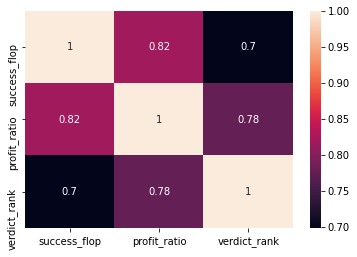

In [34]:
# Association among ordinal (categorical) measures of success
# Spearman's Rho

from scipy import stats

var_list = ['success_flop','profit_ratio','verdict_rank']

corr = pd.DataFrame()
for var1 in var_list:
    for var2 in var_list:
        rho, pval = stats.spearmanr(df_sm_miss.loc[0:,var1],df_sm_miss.loc[0:,var2])
        corr.loc[var1, var2] = rho
sns.heatmap(corr, annot=True);

In [35]:
df_sm_miss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   film                  2466 non-null   object        
 1   id                    2466 non-null   int64         
 2   rank                  2466 non-null   int64         
 3   release_date          2466 non-null   datetime64[ns]
 4   release_year          2466 non-null   int64         
 5   verdict               2466 non-null   object        
 6   verdict_rank          2466 non-null   int64         
 7   budget                2466 non-null   float64       
 8   first_week            2466 non-null   float64       
 9   tot_net_gross         2466 non-null   float64       
 10  budget_adjust         2466 non-null   float64       
 11  first_week_adjust     2466 non-null   float64       
 12  tot_net_gross_adjust  2466 non-null   float64       
 13  success_flop      

In [36]:
# success_flop, profit_ratio, verdict_rank by 5 year groups
# Adding five_year lower limits as column in dataframe

yr_limits = [(1994,2000,1995),(2000,2005,2000),(2005,2010, 2005),(2010,2015,2010),(2015,2020,2015)]

yr5_lower = []
for i in range(df_sm_miss.shape[0]):
  for yr_tup in yr_limits:
    if (df_sm_miss.loc[i,'release_year'] >= yr_tup[0] and df_sm_miss.loc[i,'release_year'] < yr_tup[1]):
      yr5_lower.append(yr_tup[2])

df_sm_miss.insert(5, 'five_yr', yr5_lower)
print(df_sm_miss.info(),'\n')

df_sm_miss.groupby('five_yr')['five_yr'].count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   film                  2466 non-null   object        
 1   id                    2466 non-null   int64         
 2   rank                  2466 non-null   int64         
 3   release_date          2466 non-null   datetime64[ns]
 4   release_year          2466 non-null   int64         
 5   five_yr               2466 non-null   int64         
 6   verdict               2466 non-null   object        
 7   verdict_rank          2466 non-null   int64         
 8   budget                2466 non-null   float64       
 9   first_week            2466 non-null   float64       
 10  tot_net_gross         2466 non-null   float64       
 11  budget_adjust         2466 non-null   float64       
 12  first_week_adjust     2466 non-null   float64       
 13  tot_net_gross_adju

five_yr
1995    475
2000    478
2005    526
2010    544
2015    443
Name: five_yr, dtype: int64

In [38]:

# regardless of the ordinal variable, the percentage of poorly performing movies remained relatively
# the same from 2000 on

print(pd.crosstab(df_sm_miss['five_yr'],df_sm_miss['success_flop'],dropna = False,margins = True,normalize='index'),'\n')
print(pd.crosstab(df_sm_miss['five_yr'],df_sm_miss['profit_ratio'],dropna = False,margins = True,normalize='index'),'\n')
print(pd.crosstab(df_sm_miss['five_yr'],df_sm_miss['verdict_rank'],dropna = False,margins = True,normalize='index'),'\n')



success_flop       0.0       1.0
five_yr                         
1995          0.631579  0.368421
2000          0.849372  0.150628
2005          0.855513  0.144487
2010          0.825368  0.174632
2015          0.828442  0.171558
All           0.799676  0.200324 

profit_ratio       1.0       2.0       3.0
five_yr                                   
1995          0.473684  0.387368  0.138947
2000          0.763598  0.192469  0.043933
2005          0.802281  0.157795  0.039924
2010          0.770221  0.167279  0.062500
2015          0.756208  0.164786  0.079007
All           0.716139  0.212084  0.071776 

verdict_rank         1         2         3  ...         7         8         9
five_yr                                     ...                              
1995          0.288421  0.416842  0.042105  ...  0.042105  0.016842  0.010526
2000          0.569038  0.230126  0.046025  ...  0.012552  0.008368  0.002092
2005          0.600760  0.195817  0.028517  ...  0.024715  0.013308  0.00190